In [1]:
# uncomment these lines to install the required dependencies.
# !pip install numpy
# !pip install matplotlib

# Übung 6: Multi-Layer-Perceptron

In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Datensatz

Wir benutzen die ``sklearn``-Version des [MNIST data set](https://en.wikipedia.org/wiki/MNIST_database). Es beinhaltet 1797 Graustufen-Bilder (8x8 Pixel) von handgeschriebenen Ziffern.

In [3]:
X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

<AxesSubplot: >

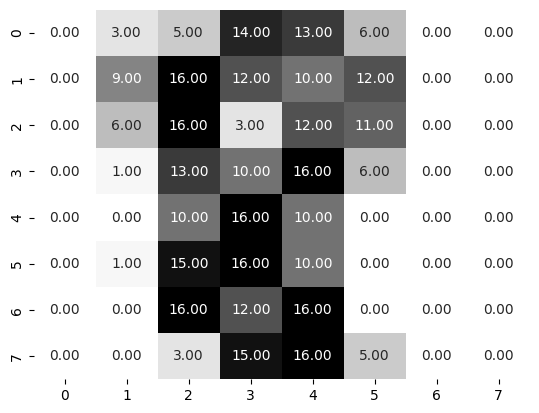

In [4]:
# plot first element of X_train
sns.heatmap(X_train[0].reshape(8, 8), annot=True, cmap='Greys', fmt=".2f", cbar=False)

### Daten normalisieren

<AxesSubplot: >

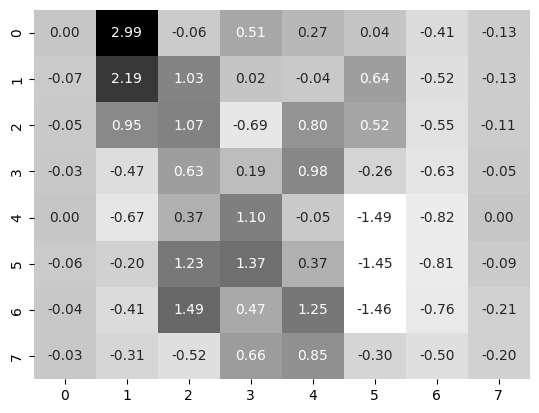

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# plot first element of X_train
sns.heatmap(X_train[0].reshape(8, 8), annot=True, cmap='Greys', fmt=".2f", cbar=False)

## Hilfsfunktionen

Wir definieren uns eine abstrakte Klasse für eine Aktivierungsfunktion. Um die Aktivierungsfunktion später austauschen zu können, implementieren wir sie als eigene Klasse.

In [6]:
from abc import ABCMeta

class Activation(metaclass=ABCMeta):
    
    def __call__(self, X):
        raise NotImplementedError()
        
    def grad(self, X):
        raise NotImplementedError()
        
    def fastgrad(self, act):
        raise NotImplementedError

### Sigmoid Aktivierungsfunktion

In [7]:
class Sigmoid(Activation):
    
    def __call__(self, X):
        return 1 / (1 + np.exp(-X))
    
    def grad(self, X):
        return np.multiply(self(X), (1 - self(X)))
    
    def fastgrad(self, act):
        return np.multiply(act, (1 - act))

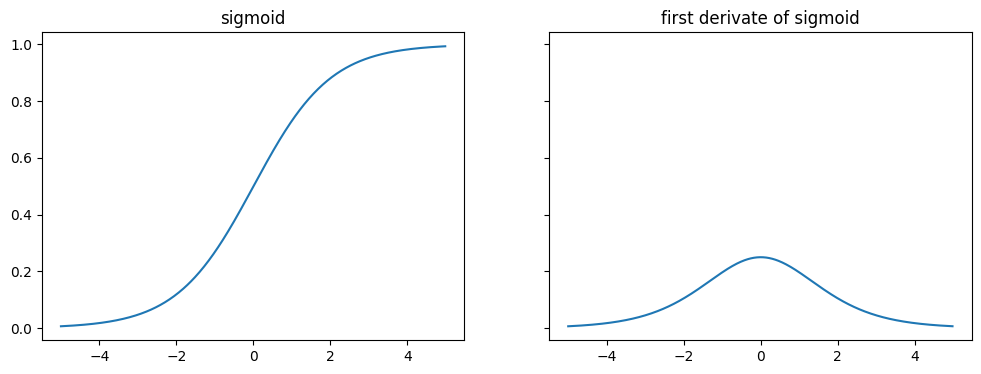

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
X_ = np.arange(-5, 5, 0.02)
ax1.plot(X_, Sigmoid()(X_))
ax1.set_title('sigmoid')
ax2.plot(X_, Sigmoid().grad(X_))
ax2.set_title('first derivate of sigmoid');

In [9]:
class Tanh(Activation):
    
    def __call__(self, X):
        return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
    
    def grad(self, X):
        return 1 - np.square(self(X))
    
    def fastgrad(self, act):
        return 1 - np.square(act)

#### Tanh Aktivierungsfunktion

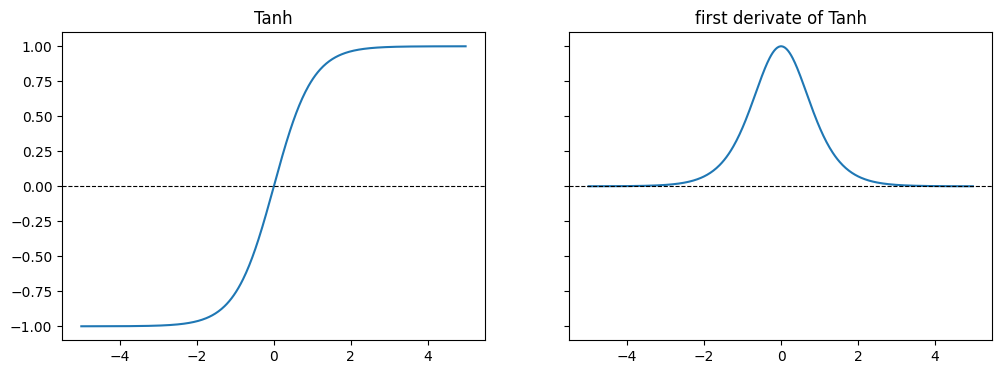

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
X_ = np.arange(-5, 5, 0.02)
ax1.plot(X_, Tanh()(X_))
ax1.set_title('Tanh')
ax1.axhline(y=0, linestyle='--', color='k', lw=0.8)
ax2.plot(X_, Tanh().grad(X_))
ax2.set_title('first derivate of Tanh');
ax2.axhline(y=0, linestyle='--', color='k', lw=0.8)

#### ReLU Aktivierungsfunktion

In [11]:
class ReLU(Activation):
    
    def __call__(self, X):
        return np.maximum(0, X)
    
    def grad(self, X):
        return 1. * (X >= 0)

    def fastgrad(self, act):
        return np.sign(act)

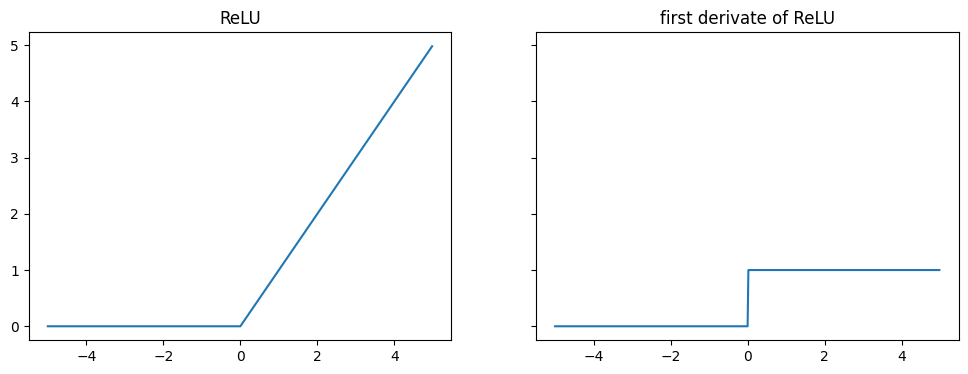

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
X_ = np.arange(-5, 5, 0.02)
ax1.plot(X_, ReLU()(X_))
ax1.set_title('ReLU')
ax2.plot(X_, ReLU().grad(X_))
ax2.set_title('first derivate of ReLU');

## Gradient Descent

Es gibt viele verschiedene Optimierungsalgorithmen, welche die Aktualisierungsregel anpassen. Um diese einfach austauschen zu können, abstrahieren dies die meisten ML-Bibliotheken etwas. Eine eigene Klasse sieht vielleicht zunächst übertrieben aus, macht aber viel Sinn, wenn man etwas kompliziertere Aktualisierungsregeln betrachtet.

In [13]:
class Optimizer(metaclass=ABCMeta):
    
    def __call__(self, weights, gradients, **kwargs):
        raise NotImplementedError()

In [14]:
class GradientDescent(Optimizer):
    
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def __call__(self, weights, gradients, **kwargs):
        return [w - self.learning_rate * g for w, g in zip(weights, gradients)]

Es kann hilfreich sein, die Lernrate dynamisch sinken zu lassen.

In [15]:
class DecayedGradientDescent(Optimizer):
    
    def __init__(self, learning_rate=0.01, decay=0.0001):
        self.learning_rate = learning_rate
        self.decay = decay
        self.last_epoch = 0
        
    def __call__(self, weights, gradients, epoch=None, **kwargs):
        result = [w - self.learning_rate * g for w, g in zip(weights, gradients)]
        
        if epoch != self.last_epoch:
            self.learning_rate = self.learning_rate * 1 / (1 + self.decay * epoch)
            self.last_epoch = epoch
            
        return result

## Loss Funktion

In [16]:
class Loss(metaclass=ABCMeta):
    
    def __call__(self, y_true, y_predicted):
        raise NotImplementedError()
        
    def grad(self, y_true, y_predicted):
        raise NotImplementedError()

In [17]:
class SquaredErrorLoss(Loss):
    
    def __call__(self, y_true, y_predicted):
        return 0.5 * np.square(y_predicted - y_true)
    
    def grad(self, y_true, y_predicted):
        return y_predicted - y_true

## Aufgabe: Multi-Layer-Perceptron (5 Punkte)

Die folgende Klasse implementiert ein Multi-Layer-Perceptron (Feed-Forward Neuronales Netz). Die Optimierung erfolgt mittels _Batch-Gradient-Descent_. Dabei steuert der Parameter `batch_size` wie viele samples für einen _Gradient Descent_-Schritt berücksichtigt werden. Ist `batch_size=1` entspricht es praktisch _Stochastic Gradient Descent_. Ist `batch_size=len(X)` entspricht es _Gradient Descent_.

Man unterscheidet oft zwischen Epochen und Iterationen:
- Epochen geben an, wie oft man durch den gesamten Trainingsdatensatz gegangen ist
- Iterationen sind abhängig von der batch size. In jeder Iteration erfolgt ein Update der Gewichtsvektoren

Aufgabe:
 - Implementieren Sie `_feed_forward`- (2P.) und die `_back_propagate`- Funktion (3P.) der `MultiLayerPerceptron`-Klasse.

**Hinweise**: 
- **Halten Sie sich an die Signaturen und Spezifikationen der gegebenen Funktionen. Lösungen mit abgeänderten Signaturen, werden mit 0 Punkten bewertet, auch wenn sie funktionieren.**
- Versuchen Sie möglichst mit vektorisierten NumPy-Operationen zu arbeiten und vermeiden Sie - wo immer möglich - python-loops über einzelne Datenpunkte. Die Geschwindigkeitsunterschiede bei diesem Beispiel sind signifikant.
- Ein gute gute Erklärung zu den einzelnen Schritten des Backpropagation-Algorithmus, sowie einer Implementierung mittels Matrixmultiplikationen, finden Sie [hier](https://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf)
- Beachten Sie die Extra-Dimension für den Intercept/Bias für die Input-Daten!
- Betrachten Sie die Funktionen, welche schon gegeben sind, versuchen Sie diese zu verstehen und verwenden Sie diese wieder, wo immer es hilfreich ist. Das betrifft inbesondere die oben definierten Hilfsfunktionen.
- Der Rückgabetyp der `_feed_forward`-Funktion ist `tuple`, d.h. es werden 2 Werte zurück gegeben.

In [18]:
class MultiLayerPerceptron:
    """
    Implementation of Feed Forward Neural Network with Backpropagation.
    
    Attributes:
        n_hidden_layers (int): number of hidden layers
        n_hidden_nodes (int): number of nodes per hidden layer
        activation (Activation): activation function
        history (dict): dictionary with keys `'train'` and `'val'` holding lists of training- and validation
            accuracy per training epoch.
        W (list of numpy.ndarray): List of 2D weight matrices, including the weights for the bias-terms. 
            A weight matrix (i x j) has i rows (one for each node in the previous layer) and j columns (one
            for each node in the respective layer).
            List items match the layers by index:
                * first list item -> weights for first hidden layer, 
                * second list item -> weights for second hidden layer,
                ...
                * last list item -> weights for output layer
        labels (numpy.ndarray): Vector of unique labels
    """
    def __init__(self, n_hidden_layers, n_hidden_nodes, activation=None):
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_nodes = n_hidden_nodes
        self.activation = activation or Sigmoid()
        self.history = {'train': [], 'val': []}
        self.W = None
        self.labels = None
    
    @staticmethod
    def add_ones(X):
        """
        Prepend a new column with ones to the data matrix for the intercept
        """
        return np.concatenate([np.ones((X.shape[0], 1)), X.copy()], axis=1)
    
    def _log_epoch(self, X, y, X_val, y_val):
        """
        calculate training and validation accuracy and append to lists in `self.history`
        """
        self.history['train'].append(accuracy_score(y, self.predict(X)))
        if X_val is not None and y_val is not None:
            self.history['val'].append(accuracy_score(y_val, self.predict(X_val)))
    
    def _init_layer(self, layer_input_dim, layer_output_dim):
        """
        initialize a layer with small random values
        """
        return np.random.normal(scale=0.1, size=(layer_input_dim + 1, layer_output_dim))
    
    def _init_weights(self, model_input_dim, model_output_dim):
        """
        initialize the weight vectors for each layer and store in `self.W`
        """
        self.W = []
        layer_dims = [model_input_dim] + [self.n_hidden_nodes] * self.n_hidden_layers + [model_output_dim]
        for i in range(1, len(layer_dims)):
            self.W.append(self._init_layer(layer_dims[i-1], layer_dims[i]))

    def fit(self, X, y, optimizer, loss, epochs=25, batch_size=32, X_val=None, y_val=None):
        """
        Trains the classifier on `X` and `y` . Logs the training accuracy at each iteration.
        If `X_val` and `y_val` are passed, the validation accuracy at each iteration is logged too.
        
        Note, that the effective batch size may differ from the passed `batch_size`, if `batch_size`
        does not equally divide the length of the training data. In this case the size of the batches is
        as equally distributed as possible.
        
        Args:
            X (numpy.ndarray): 2D training data matrix (columns->features, rows->samples)
            y (numpy.ndarray): 1D training labels vector
            optimizer (Optimizer): the optimizer instance, that performs the gradient update step
            loss (Loss): instance of an loss function object
            epochs (int): number of epochs to train the MLP
            batch_size (int): number of samples per batch
            X_val (numpy.ndarray, optional): 2D validation data matrix (columns->features, rows->samples)
            y_val (numpy.ndarray, optional): 1D validation labels vector
        
        Returns:
            None
        """
        self.labels = np.unique(y)
        input_dim, output_dim = X.shape[1], len(self.labels)
        y_one_hot = OneHotEncoder().fit_transform(y[:, None])
        self._init_weights(input_dim, output_dim)

        for i in range(epochs):
            idx = np.arange(len(X))
            np.random.shuffle(idx)
            for batch_idx in np.array_split(idx, int(np.ceil(len(X) / batch_size))):
                activations, deriv_cache = self._feed_forward(X[batch_idx])
                gradients = self._back_propagate(activations, deriv_cache, y_one_hot[batch_idx], loss)
                self.W = optimizer(self.W, gradients, epoch=i)
            self._log_epoch(X, y, X_val, y_val)
                
    def predict(self, X):
        """
        Predict the labels for all data points in `X`. 
        Predicted is label the label with the maximum output.
        
        Args:
            X (numpy.ndarray): 2D training data matrix (columns->features, rows->samples)
        
        Returns:
            numpy.ndarray: Vector of predicted labels
        """
        activations, _ = self._feed_forward(X)
        return self.labels[activations[-1].argmax(axis=1)]
    
    def _feed_forward(self, X):
        """
        Calculate the feed forward step for the input data. 
        
        The outputs at each node (activations) and the derivatives of the activation function at
        each node are cached to be reused in the backpropagation step. The input data is considered as
        output of the input layer and therefore also cached.
        
        Args:
            X (numpy.ndarray): 2D training data matrix (columns->features, rows->samples)
            
        Returns:
            list of numpy.ndarray: cached activations. 
                * The list items match the layers of the network (by index)
                * Each list entry holds a 2D-numpy array with shape len(batch) x n_nodes with the outputs for each
                    point in the batch at each node of the layer
                * The first entry holds the input data itself, which can be considered as the output of the first layer.
                * The last entry holds the outputs of the final layer.
            list of numpy.ndarray: cached derivatives
                * The list items match the layers of the network (by index), starting from the first hidden layer
                * Each list entry holds a 2D-numpy array with shape len(batch) x n_nodes holding the derivatives of 
                    the activation function at each node of the layer for each point in the batch
        """
        activations = [X]
        deriv_cache = []
        a = X
        for W in self.W:
            a = self.add_ones(a)
            z = a @ W
            a = self.activation(z)
            deriv_cache.append(self.activation.fastgrad(a))
            activations.append(a)
        return activations, deriv_cache    
    
    def _back_propagate(self, activations, deriv_cache, y_one_hot, loss):
        """
        Perform the backpropagation operation to derive the gradient of the loss function with respect
        to the weights.
        
        Args:
            activations (list of numpy.ndarray): cached activations. see `self._feed_forward`.
            deriv_cache (list of numpy.ndarray): cached derivatives. see `self._feed_forward`.
            y_one_hot (numpy.ndarray): one-hot-encoded representation of the batch-labels
            loss (Loss): The loss function to compute the gradient for.
        
        Returns:
            list of numpy.ndarray: list of 2D numpy arrays holding the gradients per layer
                * The list items match the layers of the network (by index), starting from the first hidden layer
                * The shape of each numpy-array matches the shape of the respective weights in `self.W`
        """
        delta = np.multiply(deriv_cache[-1], loss.grad(y_one_hot, activations[-1]))
        gradient = self.add_ones(activations[-2]).T @ delta
        gradients = [gradient]
        for i in range(self.n_hidden_layers, 0, -1):
            delta = np.multiply(deriv_cache[i-1], delta @ self.W[i][1:].T)
            gradient = (self.add_ones(activations[i-1]).T @ delta) / y_one_hot.shape[0]
            gradients.append(gradient)
        return gradients[::-1]


### Überprüfung

  
_Probieren Sie gerne verschiedene Optimizer, Lernraten, Epochen, Architekturen (Layer+Nodes) und Aktivierungsfunktionen aus!_

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       0.92      0.92      0.92        36
           2       1.00      0.97      0.99        35
           3       0.92      0.89      0.90        37
           4       0.94      0.94      0.94        36
           5       1.00      0.95      0.97        37
           6       0.97      0.97      0.97        36
           7       0.95      0.97      0.96        36
           8       0.91      0.83      0.87        35
           9       0.88      1.00      0.94        36

    accuracy                           0.94       360
   macro avg       0.95      0.94      0.94       360
weighted avg       0.95      0.94      0.94       360



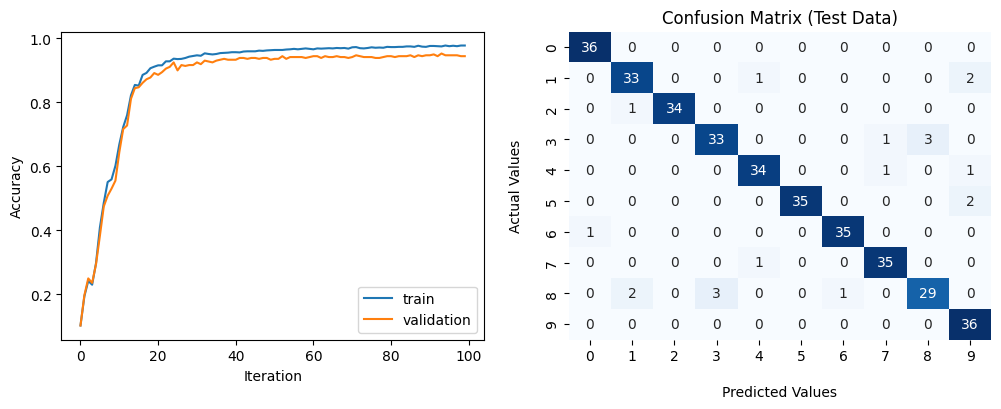

In [19]:
# train a new mlp model and predict test data
mlp = MultiLayerPerceptron(n_hidden_layers=1, n_hidden_nodes=15, activation=Sigmoid())
mlp.fit(X_train, 
        y_train, 
        optimizer=GradientDescent(learning_rate=0.1),
        loss=SquaredErrorLoss(),
        epochs=100,
        batch_size=128,
        X_val=X_test,
        y_val=y_test)
predicted = mlp.predict(X_test)

# plot training and validation accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(mlp.history['train'])
ax1.plot(mlp.history['val'])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Accuracy")
ax1.legend(['train','validation'])

# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, predicted), annot=True, cmap='Blues', fmt=".0f", cbar=False, ax=ax2)
ax2.set_title('Confusion Matrix (Test Data)')
ax2.set_xlabel('\nPredicted Values')
ax2.set_ylabel('Actual Values\n')
ax2.xaxis.set_ticklabels(mlp.labels)
ax2.yaxis.set_ticklabels(mlp.labels)

# print classification metrics
print(classification_report(y_test, predicted, target_names=list(map(str, mlp.labels.tolist()))))

### Visualisierung der Gewichte des ersten Layers

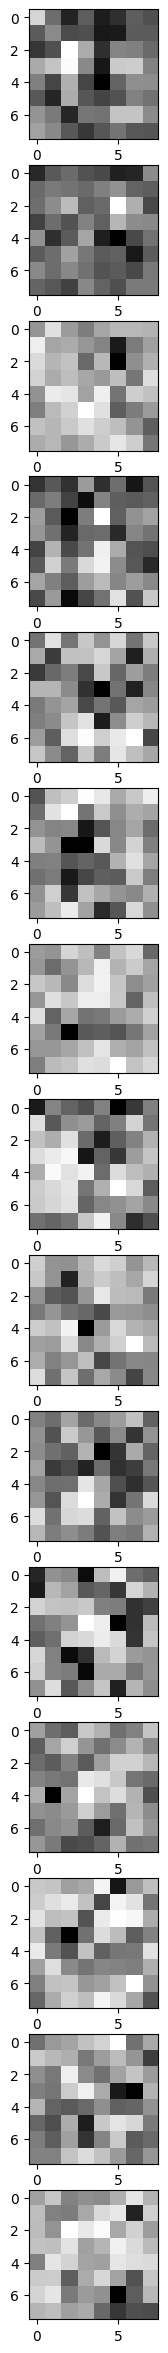

In [20]:
fig, ax = plt.subplots(mlp.W[0].shape[1], 1, figsize=(5, mlp.W[0].shape[1]*2))
for i, w in enumerate(mlp.W[0].T[:, 1:]):
    ax[i].imshow(w.reshape((8,8)), cmap='Greys')